# Single and multi-mutant primers for nearby epitopes

The purpose of this notebook is to generate a list of primers that include random mutations at important epitope sites. For pairs of epitopes that are close to each other, double-mutant primers are also generated. The codons to mutate are from the previously defined 22 major epitope sites. These will just be NNK mutants, but I want to also take into account what the actual primer lengths will be based on Tm requirements.

In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.SeqUtils import MeltingTemp as mt
import Bio

First, manually define a list of the 22 major epitope sites identified in `data/ranked-list-of-epitope-positions-for-DMS-experiments.pdf`.

In [2]:
# These epitopes are listed in HA1 numbering
epitopes_ha1 = [193, 142, 135, 138, 160, 186, 159, 261, 121, 128, 131, 144, 
                198, 171, 190, 197, 62, 192, 83, 92, 311, 326]

# convert to sequential numbering for this analysis
epitopes = [i+16 for i in epitopes_ha1]

Import WT nt sequences

In [3]:
# read in just the first entry of the sequence file
hk19_wt_nts = next(SeqIO.parse('./data/hk-45-2019.fasta', 'fasta'))
ks17_wt_nts = next(SeqIO.parse('./data/ks-14-2017.fasta', 'fasta'))

In [4]:
def ReverseComplement(seq):
    """Returns reverse complement of sequence. Preserves upper/lower case."""
    d = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'a': 't', 't': 'a', 'c': 'g',
         'g': 'c', 'N':'N'}
    rc = [d[nt] for nt in seq]
    rc.reverse()
    return ''.join(rc)

## Single epitope primers
Generate random `NNS` primers for each epitope, and write out to a csv. Note that IDT does not accept `S` as a random base, so I manually generate both `NNG` and `NNC` primers for each eptiope. This code is largely copied from `create_primers.py` in [TargetedTilingPrimers](https://github.com/jbloomlab/TargetedTilingPrimers/blob/main/create_primers.py)

In [5]:
def gen_single_primers(wt_nts, epitopes, name_prefix, random_codon_fwd_1, random_codon_fwd_2, outfile):
    
    # default primer settings
    primerlength = 37
    maxprimertm = 61
    minprimertm = 60
    minlength = 25
    maxlength = 51
    
    wt_aa = wt_nts.seq.translate()
    ncodons = len(wt_aa)
    initial_flanklength = (primerlength - 3) // 2
    
    primers = []
    for icodon in range(ncodons):
        if icodon + 1 in epitopes:
            i = icodon * 3
            five_prime = wt_nts.seq[i - initial_flanklength : i]
            three_prime = wt_nts.seq[i+3 : i+3+initial_flanklength]
            primer = f'{str(five_prime)}{random_codon_fwd_1}{str(three_prime)}'
            name = f'{name_prefix}-for-mut_epi-{icodon + 1}_{random_codon_fwd_1}'
            primerseq = Bio.Seq.Seq(primer)
            
            TmNN = ('%0.2f' % mt.Tm_NN(primerseq, strict=False))
            
            add_3 = True
            minus_5 = True
            flank5 = flank3 = initial_flanklength
            if float(TmNN) > float(maxprimertm):
                while (float(TmNN) > float(maxprimertm) and
                        len(primer) > minlength):
                    if minus_5:
                        flank5 -= 1
                        five_prime = wt_nts.seq[i - (flank5): i]
                        three_prime = wt_nts.seq[i + 3: i + 3 + flank3]
                        primer = f"{str(five_prime)}{random_codon_fwd_1}{str(three_prime)}"
                        minus_5 = False
                    else:
                        flank3 -= 1
                        five_prime = wt_nts.seq[i - (flank5): i]
                        three_prime = wt_nts.seq[i + 3: i + 3 + flank3]
                        primer = f"{str(five_prime)}{random_codon_fwd_1}{str(three_prime)}"
                        minus_5 = True
                    primerseq = Bio.Seq.Seq(primer)
                    TmNN = ('%0.2f' % mt.Tm_NN(primerseq, strict=False))
                    primerlength = len(primer)
                    
            else:
                if float(TmNN) < float(minprimertm):
                    while (float(TmNN) < float(minprimertm) and
                            len(primer) < maxlength):
                        if add_3:
                            flank3 += 1
                            five_prime = wt_nts.seq[i - (flank5): i]
                            three_prime = wt_nts.seq[i + 3: i + 3 + flank3]
                            primer = f"{str(five_prime)}{random_codon_fwd_1}{str(three_prime)}"
                            add_3 = False
                        else:
                            flank5 += 1
                            five_prime = wt_nts.seq[i - (flank5): i]
                            three_prime = wt_nts.seq[i + 3: i + 3 + flank3]
                            primer = f"{str(five_prime)}{random_codon_fwd_1}{str(three_prime)}"
                            add_3 = True
                        primerseq = Bio.Seq.Seq(primer)
                        TmNN = ('%0.2f' % mt.Tm_NN(primerseq,
                                                   strict=False))
                        primerlength = len(primer)
                        
                else:
                    pass
            
            # sub in second random primer
            primer2 = f"{str(five_prime)}{random_codon_fwd_2}{str(three_prime)}"
            name2 = f'{name_prefix}-for-mut_epi-{icodon + 1}_{random_codon_fwd_2}'
            
            # also define reverse primer
            rev_name1 = name.replace('for', 'rev')
            rev_name2 = name2.replace('for', 'rev')
            
            # because the third base of the random codon is either G or C, we can just take the
            # reverse compliment for the rev primer
            rev_primer1 = ReverseComplement(primer)
            rev_primer2 = ReverseComplement(primer2)
            
            primers.append((name, primer))
            primers.append((name2, primer2))
            primers.append((rev_name1, rev_primer1))
            primers.append((rev_name2, rev_primer2))
    
    # sort primer list to get fwd and rev pools together
    primers_sorted = sorted(primers, key = lambda x: x[0])
    
    f = open(outfile, 'w')
    for (name, primer) in primers_sorted:
        f.write(f'{name}, {primer}\r\n')
        
    return primers_sorted

In [16]:
hk19_primers = gen_single_primers(hk19_wt_nts, epitopes, 'hk19', 'NNG', 'NNC', 
                                  'results/hk19_single_epitope_primers.csv')

ks17_primers = gen_single_primers(ks17_wt_nts, epitopes, 'ks17', 'NNG', 'NNC', 
                                  'results/ks17_single_epitope_primers.csv')

print(f'Generated {len(hk19_primers)} random primers for HK19 and {len(ks17_primers)} random primers for KS17.')

Generated 88 random primers for HK19 and 88 random primers for KS17.


These numbers match up - fwd and reverse primers either with G or C in the third position for each of 22 epitopes.

## Paired epitope primers

There's definitely a more elegant way to do this, but for a one-shot analysis this is working. I loop through every defined epitope position, and generate a primer sequence that includes that epitope at the extreme 5' or 3' end of the primer. (I'm currently saying the primer would have 3 NT's between the terminus and the first mutation site, but I'm realizing this might be too short. I can edit this). Primer length is adjusted to fall in the target Tm. I then add the primer name and sequence to a list.

In [7]:
def gen_edge_primers(wt_nts, epitopes):
    
    # default primer settings
    primerlength = 37
    maxprimertm = 61
    minprimertm = 60
    minlength = 25
    maxlength = 51
    
    wt_aa = wt_nts.seq.translate()
    ncodons = len(wt_aa)
    
    # flank length is the number of nucleotides between the end of the primer and
    # the first site to mutate
    flank_length = 8
    fiveprime_epitope_primers = []
    threeprime_epitope_primers = []
    for icodon in range(ncodons):
        if icodon + 1 in epitopes:

            # add a primer where the epitope is one codon away from the 5' end
            five_prime_start = ((icodon+1) * 3) - 3 - flank_length # returns 0-indexed starting *nt* posn of primer
            primer = wt_nts.seq[five_prime_start : five_prime_start + primerlength]

            new_primerlength = primerlength
            TmNN = ('%0.2f' % mt.Tm_NN(primer, strict=False))

            # shorten primer if Tm is too high
            if float(TmNN) > float(maxprimertm):
                while (float(TmNN) > float(maxprimertm) and len(primer) > minlength):
                    # only change length from 3' end
                    new_primerlength -= 1
                    primer = wt_nts.seq[five_prime_start : five_prime_start + new_primerlength]

                    # update Tm
                    TmNN = ('%0.2f' % mt.Tm_NN(primer, strict=False))
            # lengthen primer if Tm is too low
            elif float(TmNN) < float(minprimertm):
                while (float(TmNN) < float(minprimertm) and len(primer) < maxlength):
                    new_primerlength += 1
                    primer = wt_nts.seq[five_prime_start : five_prime_start + new_primerlength]

                    TmNN = ('%0.2f' % mt.Tm_NN(primer, strict=False))
            else:
                pass

            fiveprime_epitope_primers.append((icodon+1, str(primer)))

            # and repeat to add a primer where the epitope is one codon away from the 3' end

            three_prime_end = ((icodon+1) * 3) + flank_length # returns 0-indexed ending *nt* posn of primer
            primer = wt_nts.seq[three_prime_end - primerlength + 1 : three_prime_end + 1]

            new_primerlength = primerlength
            TmNN = ('%0.2f' % mt.Tm_NN(primer, strict=False))
            if float(TmNN) > float(maxprimertm):
                while (float(TmNN) > float(maxprimertm) and len(primer) > minlength):
                    # only change length from 5' end
                    new_primerlength -= 1
                    primer = wt_nts.seq[three_prime_end - new_primerlength + 1 : three_prime_end + 1]

                    TmNN = ('%0.2f' % mt.Tm_NN(primer, strict=False))
            elif float(TmNN) < float(minprimertm):
                while (float(TmNN) < float(minprimertm) and len(primer) < maxlength):
                    new_primerlength += 1
                    primer = wt_nts.seq[three_prime_end - new_primerlength + 1 : three_prime_end + 1]

                    TmNN = ('%0.2f' % mt.Tm_NN(primer, strict=False))
            else:
                pass

            threeprime_epitope_primers.append((icodon+1, str(primer)))
    
    primer_lists = [fiveprime_epitope_primers, threeprime_epitope_primers]
    return primer_lists

In [8]:
hk19_edge_primers = gen_edge_primers(hk19_wt_nts, epitopes)
ks17_edge_primers = gen_edge_primers(ks17_wt_nts, epitopes)

print(len(hk19_edge_primers[0]), len(hk19_edge_primers[1]))
print(len(ks17_edge_primers[0]), len(ks17_edge_primers[1]))

hk19_edge_primers[0]

22 22
22 22


[(78, 'ttgatggagggaactgcacactaatagatgc'),
 (99, 'aaaataagaaatgggacctttttgttgaacgaagcag'),
 (108, 'aacgaagcagagcctacagcaactgtta'),
 (137, 'tggagtttaaaaatgaaagcttcaattgggctgg'),
 (144, 'tcaattgggctggagtcactcaaaacg'),
 (147, 'ctggagtcactcaaaacggaaaaagtttttcttg'),
 (151, 'aaaacggaaaaagtttttcttgcataaggggatctag'),
 (154, 'aaagtttttcttgcataaggggatctagtagtagtttctttagt'),
 (158, 'gcataaggggatctagtagtagtttctttagtagattaaattggt'),
 (160, 'ggggatctagtagtagtttctttagtagattaaattggttgacc'),
 (175, 'atttaaactacacatatccagcactgaacgtgactatg'),
 (176, 'taaactacacatatccagcactgaacgtgactatg'),
 (187, 'tgccaaacaaggaacaatttgacaaattgtacatttg'),
 (202, 'accacccgggtacggacaaggacca'),
 (206, 'cggacaaggaccaaatctccctgtatgc'),
 (208, 'aggaccaaatctccctgtatgctcaatcatca'),
 (209, 'accaaatctccctgtatgctcaatcatcaggaa'),
 (213, 'tgtatgctcaatcatcaggaagaatcacagtatctacc'),
 (214, 'atgctcaatcatcaggaagaatcacagtatctaccaa'),
 (277, 'tcaaaatacgaagtgggaaaagctcaataatgagatca'),
 (327, 'atgttaagcaaaacactctgaaattggcaacagg'),
 (342, 'taccag

We get two different output lists, each with 22 primers for each of the 22 epitopes. These entries are in the form `(epitope_site, primer_seq)`.

Next, we can take the length for each primer, and ask whether any other epitopes are within that range. If there are, group them as a pair, and output an evenly centered primer within the length / Tm range specified above. The epitopes of interest will be replaced with `NNG` or `NNC`.

In [9]:
def gen_paired_epitope_primers(wt_nts, edge_primers, epitopes, name_prefix, 
                               random_codon_fwd_1, random_codon_fwd_2, outfile):
    
    # default primer settings
    primerlength = 37
    maxprimertm = 61
    minprimertm = 60
    minlength = 25
    maxlength = 51
    
    fiveprime_epitope_primers = edge_primers[0]
    threeprime_epitope_primers = edge_primers[1]
    
    paired_epitopes = []
    paired_epitope_primers = []
    
    flank_length = 8

    for primer in fiveprime_epitope_primers:
        # convert primer length into codon position range
        epitope_1 = primer[0]
        primer_seq = primer[1]
        primer_nt_start = (epitope_1 * 3) - 2 - flank_length
        primer_nt_end = primer_nt_start + len(primer_seq) - 1

        # for each entry, query whether any of the other epitopes are in that range
        for epitope_2 in epitopes:
            if primer_nt_start < ((epitope_2*3)-2-flank_length) and primer_nt_end > ((epitope_2 * 3)+flank_length):
                
                # track which pairs we've already found
                paired_epitopes.append((epitope_1, epitope_2)) 
                
                # pull minimal sequence that's inclusive of the paired epitopes
                epitopes_start = (epitope_1 * 3) - 2
                epitopes_end = epitope_2 * 3
                min_primer = wt_nts.seq[epitopes_start : epitopes_end+1]
                TmNN = ('%0.2f' % mt.Tm_NN(min_primer, strict=False))

                # lengthen primer on both sides until Tm is correct
                minus_5 = True
                flank5 = flank3 = flank_length
                while (float(TmNN) < float(minprimertm) and len(primer) < maxlength):
                    if minus_5:
                        flank5 += 1
                        paired_primer = wt_nts.seq[epitopes_start - flank5 : epitopes_end + flank3 + 1]
                        primer_name = f'{name_prefix}-for-mut_epi-{epitope_1}-{epitope_2}'
                        minus_5 = False
                    else:
                        flank3 += 1
                        paired_primer = wt_nts.seq[epitopes_start - flank5 : epitopes_end + flank3 + 1]
                        primer_name = f'{name_prefix}-for-mut_epi-{epitope_1}-{epitope_2}'
                        minus_5 = True
                    TmNN = ('%0.2f' % mt.Tm_NN(paired_primer, strict=False))

                # change epitope sites to random codon by adding up seq strings based on flank lengths from previous step
                # there's probably a better way to do this
                fwd_paired_primer = str(paired_primer)
                
                primer_name1 = f'{name_prefix}-for-mut_epi-{epitope_1}-{epitope_2}_{random_codon_fwd_1}'
                random_fwd_primer1 = fwd_paired_primer[:flank5-1]+random_codon_fwd_1+fwd_paired_primer[flank5+2:len(fwd_paired_primer)-flank3-4]+random_codon_fwd_1+fwd_paired_primer[len(fwd_paired_primer)-flank3-1:]
                
                primer_name2 = f'{name_prefix}-for-mut_epi-{epitope_1}-{epitope_2}_{random_codon_fwd_2}'
                random_fwd_primer2 = fwd_paired_primer[:flank5-1]+random_codon_fwd_2+fwd_paired_primer[flank5+2:len(fwd_paired_primer)-flank3-4]+random_codon_fwd_2+fwd_paired_primer[len(fwd_paired_primer)-flank3-1:]
                
                primer_name3 = f'{name_prefix}-for-mut_epi-{epitope_1}-{epitope_2}_{random_codon_fwd_1}_{random_codon_fwd_2}'
                random_fwd_primer3 = fwd_paired_primer[:flank5-1]+random_codon_fwd_1+fwd_paired_primer[flank5+2:len(fwd_paired_primer)-flank3-4]+random_codon_fwd_2+fwd_paired_primer[len(fwd_paired_primer)-flank3-1:]
                
                primer_name4 = f'{name_prefix}-for-mut_epi-{epitope_1}-{epitope_2}_{random_codon_fwd_2}_{random_codon_fwd_1}'
                random_fwd_primer4 = fwd_paired_primer[:flank5-1]+random_codon_fwd_2+fwd_paired_primer[flank5+2:len(fwd_paired_primer)-flank3-4]+random_codon_fwd_1+fwd_paired_primer[len(fwd_paired_primer)-flank3-1:]
                
                fwd_random_primers = [(primer_name1, random_fwd_primer1), (primer_name2, random_fwd_primer2), 
                                      (primer_name3, random_fwd_primer3), (primer_name4, random_fwd_primer4)]
                
                # get reverse complement and add both to primer list
                for fwd_primer in fwd_random_primers:
                    rev_primer_name = fwd_primer[0].replace('for', 'rev')
                    rev_primer = ReverseComplement(fwd_primer[1])
                    paired_epitope_primers.append(fwd_primer)
                    paired_epitope_primers.append((rev_primer_name, rev_primer))
    
    # now check whether there's any additional pairs in threeprime_epitope_primers
    for primer in threeprime_epitope_primers:
        # convert primer length into codon position range
        epitope_2 = primer[0]
        primer_seq = primer[1]
        primer_nt_end = (epitope_2 * 3) + flank_length
        primer_nt_start = primer_nt_end - len(primer_seq) + 1

        # for each entry, query whether any of the other epitopes are in that range
        for epitope_1 in epitopes:
            if primer_nt_start < ((epitope_1*3)-2-flank_length) and primer_nt_end > ((epitope_1 * 3)+flank_length):
                if (epitope_1, epitope_2) not in paired_epitopes:
                    # Just throw an error if something's missing
                    # everything should be covered by the fiveprime edge primers
                    raise ValueError(f'missing pair: {epitope_1}_{epitope_2}')
                    
    # sort primer list to get fwd and rev pools together
    paired_epitope_primers_sorted = sorted(paired_epitope_primers, key = lambda x: x[0])
    
    f = open(outfile, 'w')
    for (name, primer) in paired_epitope_primers_sorted:
        f.write(f'{name}, {primer}\r\n')
    
    return paired_epitope_primers_sorted

In [10]:
hk19_paired_primers = gen_paired_epitope_primers(hk19_wt_nts, hk19_edge_primers, 
                                                 epitopes, 'hk19', 'NNG', 'NNC',
                                                 'results/hk19_paired_epitope_primers.csv')

ks17_paired_primers = gen_paired_epitope_primers(ks17_wt_nts, ks17_edge_primers, 
                                                 epitopes, 'ks17', 'NNG', 'NNC', 
                                                 'results/ks17_paired_epitope_primers.csv')

print(f'Generated {len(hk19_paired_primers)} paired primers for HK19 and {len(ks17_paired_primers)} paired primers for KS17.')

Generated 80 paired primers for HK19 and 72 paired primers for KS17.


My method for adding the `NNG` / `NNC`s was a little weird, but I went through the sample HK19 sequence and verified that these primers actually line up with the correct sequence and epitope position.

### Format for IDT oPools ordering

In [8]:
hk19_primers = pd.read_csv('results/hk19_single_epitope_primers.csv', header=None)
hk19_paired_primers = pd.read_csv('results/hk19_paired_epitope_primers.csv', header=None)
ks17_primers = pd.read_csv('results/ks17_single_epitope_primers.csv', header=None)
ks17_paired_primers = pd.read_csv('results/ks17_paired_epitope_primers.csv', header=None)

hk19_primers.columns = ['Pool_name', 'Sequence']
hk19_paired_primers.columns = ['Pool_name', 'Sequence']
ks17_primers.columns = ['Pool_name', 'Sequence']
ks17_paired_primers.columns = ['Pool_name', 'Sequence']

In [9]:
hk19_opool = hk19_primers.replace(regex=[r'(?<=hk19-for).*', r'(?<=hk19-rev).*'], 
                                         value='-single-epi-pool')

hk19_paired_opool = hk19_paired_primers.replace(regex=[r'(?<=hk19-for).*', r'(?<=hk19-rev).*'], 
                                                value='-paired-epi-pool')

ks17_opool = ks17_primers.replace(regex=[r'(?<=ks17-for).*', r'(?<=ks17-rev).*'], 
                                         value='-single-epi-pool')

ks17_paired_opool = ks17_paired_primers.replace(regex=[r'(?<=ks17-for).*', r'(?<=ks17-rev).*'], 
                                                value='-paired-epi-pool')

In [10]:
opool_list = [(hk19_opool, 'hk19_opool'), (hk19_paired_opool, 'hk19_paired_opool'), 
              (ks17_opool, 'ks17_opool'), (ks17_paired_opool, 'ks17_paired_opool')]

for pool, name in opool_list:
    pool.to_csv(f'results/{name}.csv', index=False)

In [11]:
opools = pd.concat([hk19_opool, hk19_paired_opool, ks17_opool, ks17_paired_opool])

In [12]:
from plotnine import *
%matplotlib inline

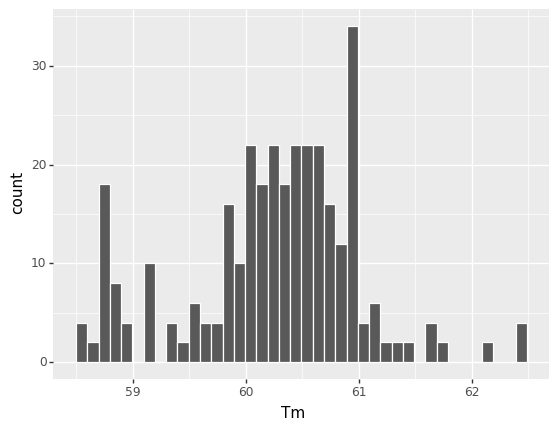

<bound method ggplot.draw of <ggplot: (8790218000597)>>

In [13]:
opools['Tm'] = opools.apply(lambda x: '%0.2f' % mt.Tm_NN(x.Sequence, strict=False), axis=1)
opools['Tm'] = opools['Tm'].astype('float')

p = (ggplot(opools) + 
     aes('Tm') + 
     geom_histogram(color='white', bins=40)
    )

p.draw